In [36]:
from IPython.display import display
import requests
import pandas as pd
import json
import sqlite3
import os

def transform_data(raw_data):
    # If the input is a string, parse it into a dictionary or list
    if isinstance(raw_data, str):
        raw_data = json.loads(raw_data)
    
    # If raw_data is a list, transform all items
    if isinstance(raw_data, list):
        return [transform_single_item(item) for item in raw_data]
    else:
        return transform_single_item(raw_data)

def transform_single_item(item):
    # Extract necessary fields from a single item
    cleaned_data = {
        'Id': item['Id'],
        'Name': item['Name'],
        'ContentType': item['ContentType'],
        'ContentLength': item['ContentLength'],
        'OriginDate': item['OriginDate'],
        'PublicationDate': item['PublicationDate'],
        'ModificationDate': item['ModificationDate'],
        'Online': item['Online'],
        'EvictionDate': item['EvictionDate'] if item['EvictionDate'] else None,
        'S3Path': item['S3Path'],
        'ContentDateStart': item['ContentDate']['Start'],
        'ContentDateEnd': item['ContentDate']['End'],
        'Footprint': item['Footprint'],
        'GeoFootprintType': item['GeoFootprint']['type'],
        'GeoFootprintCoordinates': json.dumps(item['GeoFootprint']['coordinates'])
    }
    return cleaned_data

# Make the GET request
json_response = requests.get("https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=not contains(Name,'S2') and ContentDate/Start gt 2022-05-03T00:00:00.000Z and ContentDate/Start lt 2023-05-03T00:10:00.000Z&$orderby=ContentDate/Start&$top=1000").json()

# Convert JSON to pandas DataFrame
df = pd.DataFrame.from_dict(json_response['value'])

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 1)

# Print only specific columns
columns_to_print = ['Id', 'Name', 'S3Path', 'GeoFootprint']

# Use the display function to show the DataFrame
# display(df)

# Convert the DataFrame to a JSON string and save to a file
with open('JSON/raw_data.json', 'w') as json_file:
    json_data = df.to_json(orient='records', date_format='iso', indent=4)
    json_file.write(json_data)

# Convert the DataFrame to a NDJSON string and save to a file
with open('NDJSON/raw_data.ndjson', 'w') as jsonl_file:
    jsonl_data = df.to_json(orient='records', lines=True, date_format='iso')
    jsonl_file.write(jsonl_data)

# Clean the data
cleaned_data = transform_data(json_data)

with open('JSON/cleaned_data.json', 'w') as json_file:
    json.dump(cleaned_data, json_file, indent=4)

with open('NDJSON/cleaned_data.ndjson', 'w') as jsonl_file:
    for data in cleaned_data:
        jsonl_file.write(json.dumps(data) + '\n')

In [ ]:
# Create the SQLite folder if it doesn't exist
if not os.path.exists('SQLite'):
    os.makedirs('SQLite')

# Establish a connection to the SQLite database inside the SQLite folder
conn = sqlite3.connect('SQLite/SentinelData.db')
cursor = conn.cursor()

# Create the table
cursor.execute('''
CREATE TABLE IF NOT EXISTS SentinelData (
    Id CHAR(36) PRIMARY KEY,
    Name VARCHAR(255),
    ContentType VARCHAR(255),
    ContentLength BIGINT,
    OriginDate DATETIME(3),
    PublicationDate DATETIME(3),
    ModificationDate DATETIME(3),
    Online BOOLEAN,
    EvictionDate DATETIME(3) DEFAULT NULL,
    S3Path TEXT,
    ContentDateStart DATETIME(3),
    ContentDateEnd DATETIME(3),
    Footprint TEXT,
    GeoFootprintType VARCHAR(50),
    GeoFootprintCoordinates TEXT
);
''')

# Insert the cleaned_data into the table
for data in cleaned_data:
    cursor.execute('''
    INSERT INTO SentinelData (
        Id, Name, ContentType, ContentLength, OriginDate, PublicationDate, 
        ModificationDate, Online, EvictionDate, S3Path, ContentDateStart, 
        ContentDateEnd, Footprint, GeoFootprintType, GeoFootprintCoordinates
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        data['Id'], data['Name'], data['ContentType'], data['ContentLength'], 
        data['OriginDate'], data['PublicationDate'], data['ModificationDate'], 
        data['Online'], data['EvictionDate'], data['S3Path'], data['ContentDateStart'], 
        data['ContentDateEnd'], data['Footprint'], data['GeoFootprintType'], 
        data['GeoFootprintCoordinates']
    ))

# Commit the changes and close the connection
conn.commit()
conn.close()

Fontconfig warning: ignoring UTF-8: not a valid region tag


Authenticated using refresh token.


/var/folders/s8/85p9mfnx4xv2xn6nnxj53n1w0000gp/T/ipykernel_16288/3251188153.py:54: UserDeprecationWarning: Call to deprecated method create_job. (Usage of this legacy method is deprecated. Use `.create_job` instead.) -- Deprecated since version 0.10.0.
  job = nbr.send_job()


0:00:00 Job 'j-2311041c486e4e8189a0744e53277d06': send 'start'
0:00:30 Job 'j-2311041c486e4e8189a0744e53277d06': created (progress N/A)
0:00:37 Job 'j-2311041c486e4e8189a0744e53277d06': running (progress N/A)
0:00:43 Job 'j-2311041c486e4e8189a0744e53277d06': running (progress N/A)
0:00:51 Job 'j-2311041c486e4e8189a0744e53277d06': running (progress N/A)
0:01:01 Job 'j-2311041c486e4e8189a0744e53277d06': running (progress N/A)
0:01:13 Job 'j-2311041c486e4e8189a0744e53277d06': running (progress N/A)
0:01:29 Job 'j-2311041c486e4e8189a0744e53277d06': finished (progress N/A)


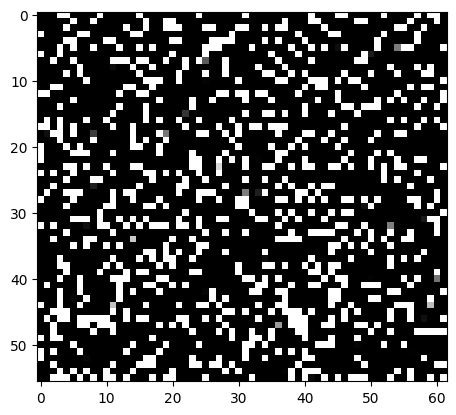

In [6]:
#Prototype

import openeo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# connect with the backend
eoconn = openeo.connect(
       "openeo.dataspace.copernicus.eu"
        ).authenticate_oidc()

# Setup process parameters
aoi = {
        "type": "Polygon",
        "coordinates": [
          [
            [
              5.179324150085449,
              51.2498689148547
            ],
            [
              5.178744792938232,
              51.24672597710759
            ],
            [
              5.185289382934569,
              51.24504696935156
            ],
            [
              5.18676996231079,
              51.245342479161295
            ],
            [
              5.187370777130127,
              51.24918393390799
            ],
            [
              5.179324150085449,
              51.2498689148547
            ]
          ]
        ]
      }
date = ["2020-06-27","2020-07-27"]


#Create a processing graph from the NBR process using an active openEO connection
nbr = eoconn.datacube_from_process(
    namespace="https://openeo.dataspace.copernicus.eu/openeo/1.1/processes/u:3e24e251-2e9a-438f-90a9-d4500e576574/NBR",
      process_id = "NBR",
      date = date,
      aoi = aoi
      )

# Execute the process and download the result
job = nbr.send_job()
job.start_and_wait()
result = job.get_results()
download = result.download_file("/Users/alexandru/Downloads/Docs/MyDocs/Copernicus")

# Assuming the result is an image, use matplotlib to display it
img = mpimg.imread(download)
plt.imshow(img)
plt.show()


In [8]:
import openeo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# connect with the backend
eoconn = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

# Setup process parameters
aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [5.179324150085449, 51.2498689148547],
            [5.178744792938232, 51.24672597710759],
            [5.185289382934569, 51.24504696935156],
            [5.18676996231079, 51.245342479161295],
            [5.187370777130127, 51.24918393390799],
            [5.179324150085449, 51.2498689148547]
        ]
    ]
}
date = ["2020-06-27", "2020-07-27"]

# Create a processing graph from the NBR process using an active openEO connection
# Note: The namespace and process_id should be verified from the OpenEO backend documentation
nbr = eoconn.load_collection(
    "SENTINEL2_L2A_SENTINELHUB",
    spatial_extent=aoi,
    temporal_extent=date,
    bands=["B8A", "B12"]
).normalized_difference(
    "B8A", "B12"
)

# Execute the process and download the result
job = nbr.send_job()
if job:
    job.start_and_wait()
    result = job.get_results()
    if result:
        # Define the download path
        download_path = "/Users/alexandru/Downloads/Docs/MyDocs/Copernicus"
        os.makedirs(download_path, exist_ok=True)
        download = result.download_file(download_path)

        # Assuming the result is an image, use matplotlib to display it
        img = mpimg.imread(download)
        plt.imshow(img)
        plt.show()
    else:
        print("No result from job.")
else:
    print("Job submission failed.")

Authenticated using refresh token.


OpenEoApiError: [404] CollectionNotFound: Collection 'SENTINEL2_L2A_SENTINELHUB' does not exist. (ref: r-231104d98f1741a7aea53689e3e1cb47)